In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Setting plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
import pandas as pd
df=pd.read_csv('realtor-data.zip.csv')
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [13]:
# viewing information about the dataset
print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("Column Info:")
print(df.info())
print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum())

Dataset Shape: (2226382, 12)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB
None

Missing Values:
brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64


In [15]:
# Before cleaning
print("Before cleaning:")
print(f"Total rows: {len(df)}")

# Removing rows with missing essential data for modeling
df_clean = df.dropna(subset=['price', 'house_size', 'bed', 'bath', 'state'])

# Removing invalid data (negative or zero values where they shouldn't be)
df_clean = df_clean[
    (df_clean['price'] > 0) & 
    (df_clean['house_size'] > 0) & 
    (df_clean['bed'] > 0) & 
    (df_clean['bath'] > 0)
]

# Removing extreme outliers
df_clean = df_clean[
    (df_clean['price'] >= 10000) & 
    (df_clean['price'] <= 10000000) &
    (df_clean['house_size'] <= 20000) &  # Remove huge outliers
    (df_clean['bed'] <= 10) &  # Reasonable number of bedrooms
    (df_clean['bath'] <= 10)   # Reasonable number of bathrooms
]

print(f"\nAfter cleaning:")
print(f"Total rows: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} rows ({((len(df) - len(df_clean))/len(df)*100):.1f}%)")
print(f"We still have {len(df_clean):,} properties for analysis!")

Before cleaning:
Total rows: 2226382

After cleaning:
Total rows: 1598304
Removed 628078 rows (28.2%)
We still have 1,598,304 properties for analysis!


In [17]:
# Creating useful features
df_clean['price_per_sqft'] = df_clean['price'] / df_clean['house_size']
df_clean['total_rooms'] = df_clean['bed'] + df_clean['bath']

# Creating price categories
df_clean['price_category'] = pd.cut(df_clean['price'], 
                                   bins=[0, 200000, 500000, 1000000, float('inf')],
                                   labels=['Budget', 'Mid-range', 'High-end', 'Luxury'])

print("New features created!")
print("\nPrice category distribution:")
print(df_clean['price_category'].value_counts())
print("\nBasic stats on new features:")
print(df_clean[['price_per_sqft', 'total_rooms']].describe())

New features created!

Price category distribution:
price_category
Mid-range    761657
High-end     370807
Budget       319622
Luxury       146218
Name: count, dtype: int64

Basic stats on new features:
       price_per_sqft   total_rooms
count    1.598304e+06  1.598304e+06
mean     2.730661e+02  5.701867e+00
std      4.483507e+02  1.935646e+00
min      1.846381e+00  2.000000e+00
25%      1.426205e+02  5.000000e+00
50%      2.010724e+02  5.000000e+00
75%      3.062950e+02  7.000000e+00
max      4.625000e+05  2.000000e+01


Top 15 states by number of properties:
state
California        190055
Florida           182543
Texas             158107
New York           67081
Illinois           64057
Pennsylvania       57756
Arizona            56124
Georgia            54658
Virginia           54331
Washington         52243
Ohio               45874
North Carolina     42877
Maryland           39738
Massachusetts      35177
Minnesota          35109
Name: count, dtype: int64


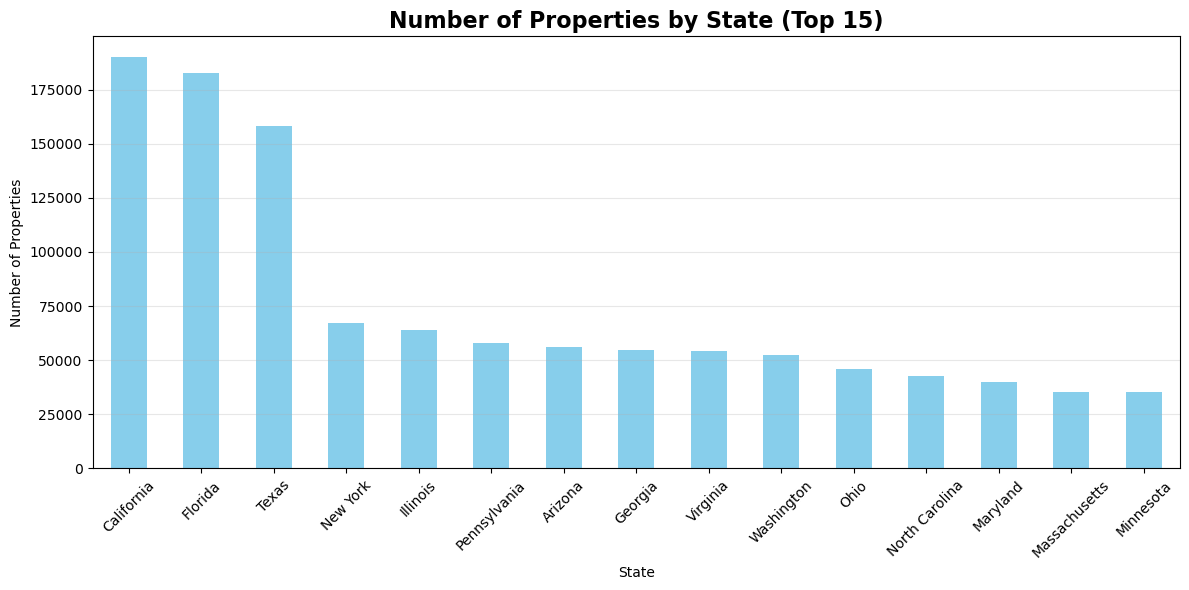

In [19]:
# Seeing which states we have most data for
print("Top 15 states by number of properties:")
state_counts = df_clean['state'].value_counts().head(15)
print(state_counts)

# Plotting state distribution
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Properties by State (Top 15)', fontsize=16, fontweight='bold')
plt.xlabel('State')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

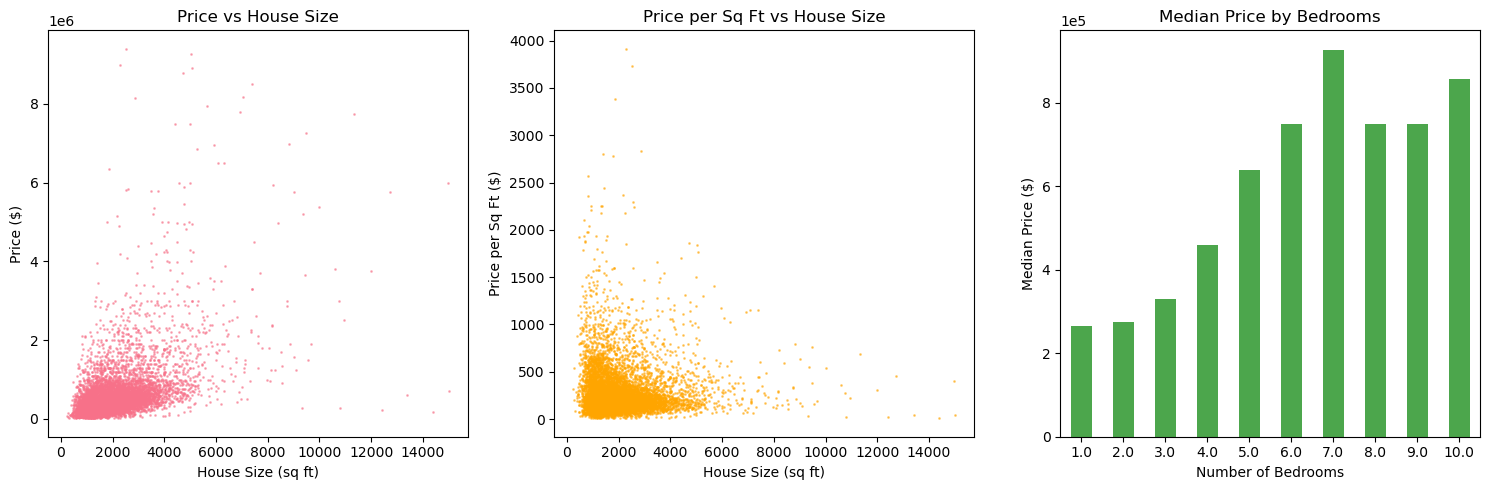

Correlation with Price:
price             1.000000
bath              0.494824
house_size        0.493174
price_per_sqft    0.422331
bed               0.269620
Name: price, dtype: float64


In [21]:
# Sample data for plotting (1.6M points is too many)
sample_df = df_clean.sample(n=10000, random_state=42)

plt.figure(figsize=(15, 5))

# Subplot 1: Price vs House Size
plt.subplot(1, 3, 1)
plt.scatter(sample_df['house_size'], sample_df['price'], alpha=0.5, s=1)
plt.xlabel('House Size (sq ft)')
plt.ylabel('Price ($)')
plt.title('Price vs House Size')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Subplot 2: Price per sqft vs House Size
plt.subplot(1, 3, 2)
plt.scatter(sample_df['house_size'], sample_df['price_per_sqft'], alpha=0.5, s=1, color='orange')
plt.xlabel('House Size (sq ft)')
plt.ylabel('Price per Sq Ft ($)')
plt.title('Price per Sq Ft vs House Size')

# Subplot 3: Bedrooms vs Price
plt.subplot(1, 3, 3)
bedroom_prices = df_clean.groupby('bed')['price'].median()
bedroom_prices.plot(kind='bar', color='green', alpha=0.7)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Median Price ($)')
plt.title('Median Price by Bedrooms')
plt.xticks(rotation=0)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

# Calculating correlation
correlation = df_clean[['price', 'house_size', 'bed', 'bath', 'price_per_sqft']].corr()
print("Correlation with Price:")
print(correlation['price'].sort_values(ascending=False))

Price analysis for top 10 states (by property count):
                median           mean   count
state                                        
California    699000.0  953475.366504  190055
Washington    550000.0  692372.127366   52243
Arizona       419900.0  530974.929264   56124
Virginia      400000.0  512845.730449   54331
New York      389000.0  790544.385758   67081
Florida       369000.0  575310.391278  182543
Texas         336990.0  438993.158902  158107
Georgia       331545.0  413030.011160   54658
Illinois      267840.0  359183.338480   64057
Pennsylvania  265000.0  348603.103349   57756


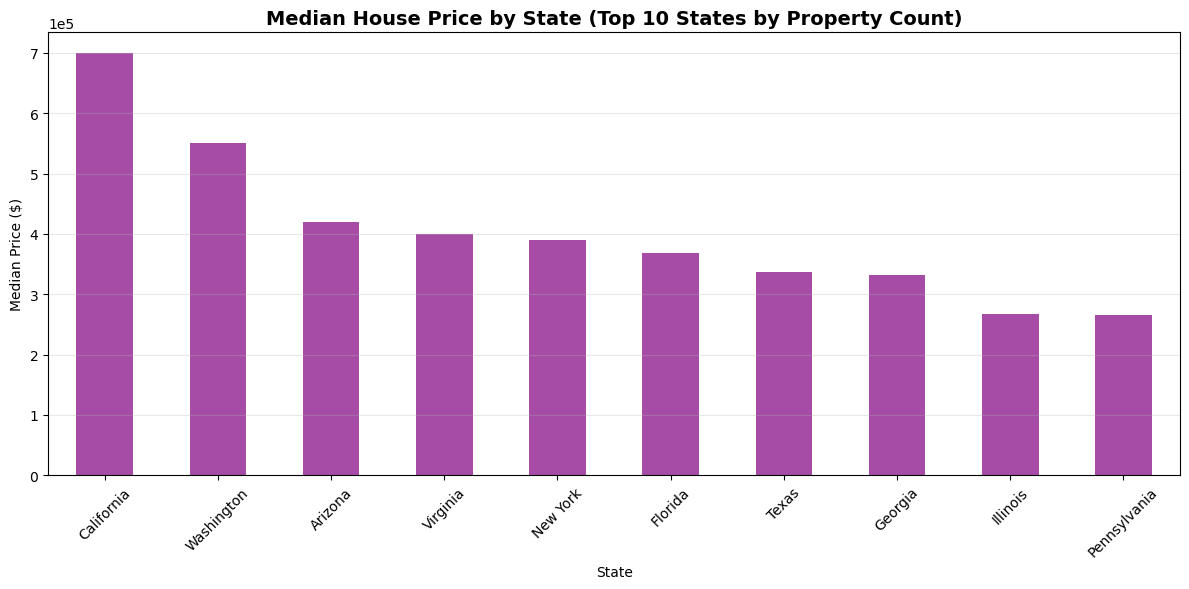

In [23]:
# Top 10 states by median price
top_states = df_clean['state'].value_counts().head(10).index
state_prices = df_clean[df_clean['state'].isin(top_states)].groupby('state')['price'].agg(['median', 'mean', 'count']).sort_values('median', ascending=False)

print("Price analysis for top 10 states (by property count):")
print(state_prices)

# Plotting median prices by state
plt.figure(figsize=(12, 6))
state_prices['median'].plot(kind='bar', color='purple', alpha=0.7)
plt.title('Median House Price by State (Top 10 States by Property Count)', fontsize=14, fontweight='bold')
plt.xlabel('State')
plt.ylabel('Median Price ($)')
plt.xticks(rotation=45)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# Preparing data for machine learning
print("Preparing data for ML model...")

# Selecting features based on correlation analysis (removed price_per_sqft to avoid data leakage)
features = ['house_size', 'bath', 'bed']
X = df_clean[features].copy()

# Adding state as dummy variables - only top 10 states to keep it manageable
top_10_states = ['California', 'Florida', 'Texas', 'New York', 'Illinois', 
                 'Pennsylvania', 'Arizona', 'Georgia', 'Virginia', 'Washington']

# Filtering data to only include top 10 states
df_filtered = df_clean[df_clean['state'].isin(top_10_states)].copy()
X_filtered = df_filtered[features].copy()

# Creating state dummies for top 10 states
state_dummies = pd.get_dummies(df_filtered['state'], prefix='state')
X_filtered = pd.concat([X_filtered, state_dummies], axis=1)

# Target variable
y_filtered = df_filtered['price']

print(f"Filtered to top 10 states:")
print(f"Features shape: {X_filtered.shape}")
print(f"Target shape: {y_filtered.shape}")
print(f"Feature columns: {list(X_filtered.columns)}")
print(f"Sample size: {len(df_filtered):,} properties")

Preparing data for ML model...
Filtered to top 10 states:
Features shape: (936955, 13)
Target shape: (936955,)
Feature columns: ['house_size', 'bath', 'bed', 'state_Arizona', 'state_California', 'state_Florida', 'state_Georgia', 'state_Illinois', 'state_New York', 'state_Pennsylvania', 'state_Texas', 'state_Virginia', 'state_Washington']
Sample size: 936,955 properties


In [29]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Training multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Training the model
    model.fit(X_train, y_train)
    
    # Making predictions
    y_pred = model.predict(X_test)
    
    # Calculating metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'r2_score': r2,
        'mae': mae,
        'predictions': y_pred
    }
    
    print(f"{name} - R² Score: {r2:.4f}, MAE: ${mae:,.0f}")

# Finding best model
best_model_name = max(results.keys(), key=lambda k: results[k]['r2_score'])
best_model = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Best R² Score: {results[best_model_name]['r2_score']:.4f}")

Training set: 749,564 samples
Test set: 187,391 samples

Training Linear Regression...
Linear Regression - R² Score: 0.3984, MAE: $310,228

Training Random Forest...
Random Forest - R² Score: 0.4566, MAE: $256,421

Best Model: Random Forest
Best R² Score: 0.4566


Feature Importance:
               feature  importance
0           house_size    0.438178
1                 bath    0.327395
4     state_California    0.082751
2                  bed    0.067315
8       state_New York    0.029738
5        state_Florida    0.025749
12    state_Washington    0.011204
3        state_Arizona    0.007799
10         state_Texas    0.003406
11      state_Virginia    0.001719
9   state_Pennsylvania    0.001631
7       state_Illinois    0.001631
6        state_Georgia    0.001484


<Figure size 1000x600 with 0 Axes>

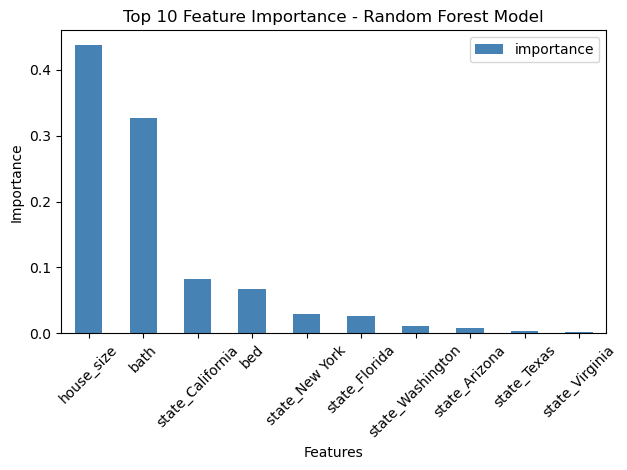

In [33]:
# Feature importance ( Works with Random Forest)
if best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': X_filtered.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Feature Importance:")
    print(feature_importance)
    
    # Plotting feature importance
    plt.figure(figsize=(10, 6))
    feature_importance.head(10).plot(x='feature', y='importance', kind='bar', color='steelblue')
    plt.title('Top 10 Feature Importance - Random Forest Model')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

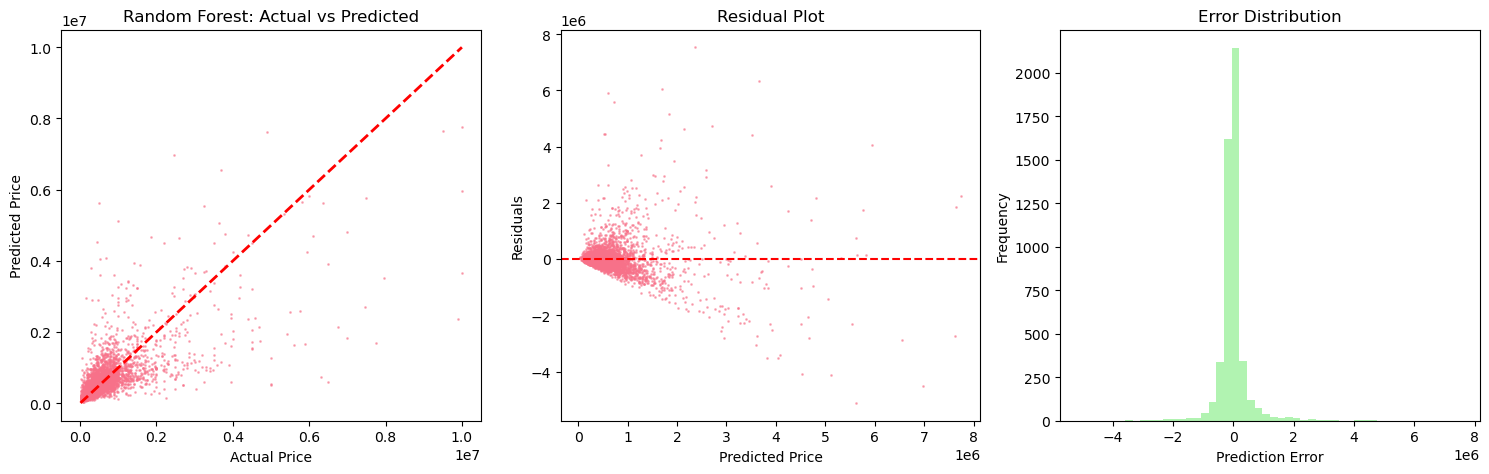


Model Performance Summary:
Best Model: Random Forest
R² Score: 0.4566 (explains 45.7% of price variation)
Mean Absolute Error: $256,421


In [36]:
# Model evaluation
best_predictions = results[best_model_name]['predictions']

# Plotting actual vs predicted
plt.figure(figsize=(15, 5))

# Subplot 1: Actual vs Predicted (sample for visibility)
plt.subplot(1, 3, 1)
sample_idx = np.random.choice(len(y_test), 5000, replace=False)
plt.scatter(y_test.iloc[sample_idx], best_predictions[sample_idx], alpha=0.5, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'{best_model_name}: Actual vs Predicted')

# Subplot 2: Residuals
plt.subplot(1, 3, 2)
residuals = y_test.iloc[sample_idx] - best_predictions[sample_idx]
plt.scatter(best_predictions[sample_idx], residuals, alpha=0.5, s=1)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Subplot 3: Error distribution
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=50, alpha=0.7, color='lightgreen')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"Best Model: {best_model_name}")
print(f"R² Score: {results[best_model_name]['r2_score']:.4f} (explains {results[best_model_name]['r2_score']*100:.1f}% of price variation)")
print(f"Mean Absolute Error: ${results[best_model_name]['mae']:,.0f}")